In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
# 读入数据/标签 生成x_train  y_train
df = pd.read_csv("./datas/dot.csv")
x_data = np.array(df[['x1','x2']])
y_data = np.array(df['y_c'])

x_train = np.vstack(x_data).reshape(-1,2)
y_train = np.vstack(y_data).reshape(-1,1)

Y_c = [['red' if y else 'blue'] for y in y_train]

In [7]:
# 转换x的数据类型
x_train = tf.cast(x_train,tf.float32)
y_train = tf.cast(y_train,tf.float32)

epoch: 0 loss 5.720865726470947
epoch: 200 loss 0.11033477634191513
epoch: 400 loss 0.05563202500343323
epoch: 600 loss 0.0317341648042202
epoch: 800 loss 0.021642571315169334
********predict**************


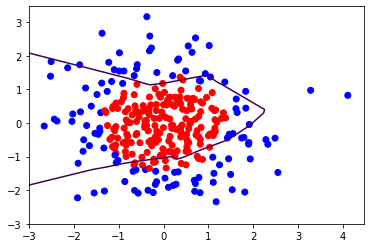

In [48]:
# from_tensor_slices 函数切分传入张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
# 生成神经网络的参数，输入层为两个神经元，隐藏层为11个神经元，1隐藏层，输出层为1个神经元
# 用tf.Variable*()保证参数可训练

w1 = tf.Variable(tf.random.normal([2,11]),dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01,shape=[11]))

w2 = tf.Variable(tf.random.normal([11,1]),dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01,shape=[1]))

lr = 0.005
epoch = 1000

# 训练部分
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            h1 = tf.matmul(x_train, w1) + b1
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1,w2) + b2
            
            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss = tf.reduce_mean(tf.square(y_train-y))
            
        # 计算loss对各个参数的梯度
        variables = [w1,b1,w2,b2]
        grads = tape.gradient(loss,variables)
        
        # 实现梯度更新
        # w1 = w1 - lr*w1_grad  tape.gradient是自动求导结果与[w1, b1, w2, b2] 索引为0，1，2，3 
        w1.assign_sub(lr*grads[0])
        b1.assign_sub(lr*grads[1])
        w2.assign_sub(lr*grads[2])
        b2.assign_sub(lr*grads[3])
        
    # 每20个epoch,打印loss信息
    if epoch % 200 == 0:
        print('epoch:',epoch,'loss',float(loss))
        
# 预测部分
print("********predict**************")

# xx在-3 到 3 之间以步长为 0.01，yy在 -3 到 3 之间以步长 0.01 生成间隔数值点
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]

# 将xx, yy 拉直，合并并配对为二位张量，生成二维坐标点
grid = np.c_[xx.ravel(),yy.ravel()]
grid = tf.cast(grid, tf.float32)

# 将网络坐标点喂入神经网络，进行预测，probs为输出
probs = []
for x_test in grid:
    # 使训练好的参数进行预测
    h1 = tf.matmul([x_test],w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1,w2)+b2
    probs.append(y)
    
# 取第0列给x1,取第二列给x2
x1 = x_data[:,0]
x2 = x_data[:,1]

# probs的shape调整成xx的样子
probs = np.array(probs).reshape(xx.shape)
plt.scatter(x1,x2,color=np.squeeze(Y_c)) # squeeze去掉纬度是1的纬度,相当于去掉[['red'],['blue']],内层括号变为['red','blue']

# 把坐标xx，yy和对应的值probs放入counter函数，给probs值为0.5的所有点上色
plt.contour(xx,yy,probs,levels=[.5])
plt.show()

## 加入L2正则化

epoch: 0 loss 8.751338958740234
epoch: 200 loss 0.6113419532775879
epoch: 400 loss 0.5373849868774414
epoch: 600 loss 0.4941759705543518
epoch: 800 loss 0.45886343717575073
********predict**************


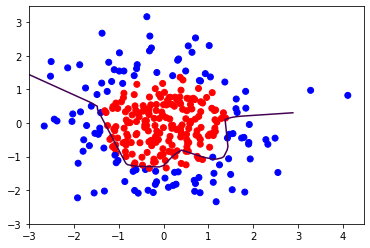

In [49]:

# from_tensor_slices 函数切分传入张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
# 生成神经网络的参数，输入层为两个神经元，隐藏层为11个神经元，1隐藏层，输出层为1个神经元
# 用tf.Variable*()保证参数可训练

w1 = tf.Variable(tf.random.normal([2,11]),dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01,shape=[11]))

w2 = tf.Variable(tf.random.normal([11,1]),dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01,shape=[1]))

lr = 0.005
epoch = 1000

# 训练部分
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            h1 = tf.matmul(x_train, w1) + b1
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1,w2) + b2
            
            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_mse = tf.reduce_mean(tf.square(y_train-y))
            # 添加L2正则化
            loss_regularization = []
            # tf.nn.l2_loss(w) = sum(w**2)/2
            loss_regularization.append(tf.nn.l2_loss(w1))
            loss_regularization.append(tf.nn.l2_loss(w2))
            
            loss_regularization =tf.reduce_sum(loss_regularization)
            loss = loss_mse + 0.03 * loss_regularization  # regularzer = 0.03
            
        # 计算loss对各个参数的梯度
        variables = [w1,b1,w2,b2]
        grads = tape.gradient(loss,variables)
        
        # 实现梯度更新
        # w1 = w1 - lr*w1_grad  tape.gradient是自动求导结果与[w1, b1, w2, b2] 索引为0，1，2，3 
        w1.assign_sub(lr*grads[0])
        b1.assign_sub(lr*grads[1])
        w2.assign_sub(lr*grads[2])
        b2.assign_sub(lr*grads[3])
        
    # 每20个epoch,打印loss信息
    if epoch % 200 == 0:
        print('epoch:',epoch,'loss',float(loss))
        
# 预测部分
print("********predict**************")

# xx在-3 到 3 之间以步长为 0.01，yy在 -3 到 3 之间以步长 0.01 生成间隔数值点
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]

# 将xx, yy 拉直，合并并配对为二位张量，生成二维坐标点
grid = np.c_[xx.ravel(),yy.ravel()]
grid = tf.cast(grid, tf.float32)

# 将网络坐标点喂入神经网络，进行预测，probs为输出
probs = []
for x_test in grid:
    # 使训练好的参数进行预测
    h1 = tf.matmul([x_test],w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1,w2)+b2
    probs.append(y)
    
# 取第0列给x1,取第二列给x2
x1 = x_data[:,0]
x2 = x_data[:,1]

# probs的shape调整成xx的样子
probs = np.array(probs).reshape(xx.shape)
plt.scatter(x1,x2,color=np.squeeze(Y_c)) # squeeze去掉纬度是1的纬度,相当于去掉[['red'],['blue']],内层括号变为['red','blue']

# 把坐标xx，yy和对应的值probs放入counter函数，给probs值为0.5的所有点上色
plt.contour(xx,yy,probs,levels=[.5])
plt.show()

#### 优化器

In [51]:
import tensorflow as tf
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import time

In [52]:
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

In [53]:
# 随机打乱数据,加入seed使一致
np.random.seed(116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

In [55]:
# 分割数据为训练集和测试集
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

In [56]:
# 转换数据类型使保持一致
x_train = tf.cast(x_train,tf.float32)
x_test = tf.cast(x_test,tf.float32)

In [57]:
# 数据集制作
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [58]:
# 生成神经网络的参数，4个输入特征，输入层为4个输入节点；三分类，输出层为3个神经元
w1 = tf.Variable(tf.random.truncated_normal([4,3],stddev=0.1,seed =1))
b1 = tf.Variable(tf.random.truncated_normal([3],stddev=0.1,seed =1))

lr = 0.1
train_loss_results = []
test_acc = []
epoch = 500
loss_all = 0  # 每轮4个step（150条数据/32）,loss_all 记录4个step生成的4个loss的和

epoch: 0,loss:0.021140425000339746
test_acc: 1.0
---------------------------------
epoch: 1,loss:0.021137985633686185
test_acc: 1.0
---------------------------------
epoch: 2,loss:0.021135546965524554
test_acc: 1.0
---------------------------------
epoch: 3,loss:0.021133102010935545
test_acc: 1.0
---------------------------------
epoch: 4,loss:0.02113067079335451
test_acc: 1.0
---------------------------------
epoch: 5,loss:0.021128220483660698
test_acc: 1.0
---------------------------------
epoch: 6,loss:0.021125798346474767
test_acc: 1.0
---------------------------------
epoch: 7,loss:0.02112336177378893
test_acc: 1.0
---------------------------------
epoch: 8,loss:0.021120931720361114
test_acc: 1.0
---------------------------------
epoch: 9,loss:0.02111850422807038
test_acc: 1.0
---------------------------------
epoch: 10,loss:0.021116080693900585
test_acc: 1.0
---------------------------------
epoch: 11,loss:0.021113654132932425
test_acc: 1.0
---------------------------------
epoch

test_acc: 1.0
---------------------------------
epoch: 102,loss:0.02090051374398172
test_acc: 1.0
---------------------------------
epoch: 103,loss:0.020898242481052876
test_acc: 1.0
---------------------------------
epoch: 104,loss:0.02089598262682557
test_acc: 1.0
---------------------------------
epoch: 105,loss:0.020893727196380496
test_acc: 1.0
---------------------------------
epoch: 106,loss:0.02089147688820958
test_acc: 1.0
---------------------------------
epoch: 107,loss:0.020889213541522622
test_acc: 1.0
---------------------------------
epoch: 108,loss:0.020886961137875915
test_acc: 1.0
---------------------------------
epoch: 109,loss:0.020884711295366287
test_acc: 1.0
---------------------------------
epoch: 110,loss:0.02088246075436473
test_acc: 1.0
---------------------------------
epoch: 111,loss:0.020880207186564803
test_acc: 1.0
---------------------------------
epoch: 112,loss:0.020877961767837405
test_acc: 1.0
---------------------------------
epoch: 113,loss:0.020

epoch: 213,loss:0.02065904508344829
test_acc: 1.0
---------------------------------
epoch: 214,loss:0.020656953565776348
test_acc: 1.0
---------------------------------
epoch: 215,loss:0.02065487438812852
test_acc: 1.0
---------------------------------
epoch: 216,loss:0.020652777515351772
test_acc: 1.0
---------------------------------
epoch: 217,loss:0.02065069740638137
test_acc: 1.0
---------------------------------
epoch: 218,loss:0.02064861450344324
test_acc: 1.0
---------------------------------
epoch: 219,loss:0.020646526012569666
test_acc: 1.0
---------------------------------
epoch: 220,loss:0.020644444972276688
test_acc: 1.0
---------------------------------
epoch: 221,loss:0.020642356015741825
test_acc: 1.0
---------------------------------
epoch: 222,loss:0.020640280796214938
test_acc: 1.0
---------------------------------
epoch: 223,loss:0.020638203946873546
test_acc: 1.0
---------------------------------
epoch: 224,loss:0.020636121043935418
test_acc: 1.0
------------------

test_acc: 1.0
---------------------------------
epoch: 320,loss:0.020443181972950697
test_acc: 1.0
---------------------------------
epoch: 321,loss:0.02044123993255198
test_acc: 1.0
---------------------------------
epoch: 322,loss:0.02043929579667747
test_acc: 1.0
---------------------------------
epoch: 323,loss:0.020437362138181925
test_acc: 1.0
---------------------------------
epoch: 324,loss:0.020435422891750932
test_acc: 1.0
---------------------------------
epoch: 325,loss:0.02043347992002964
test_acc: 1.0
---------------------------------
epoch: 326,loss:0.020431534154340625
test_acc: 1.0
---------------------------------
epoch: 327,loss:0.020429602125659585
test_acc: 1.0
---------------------------------
epoch: 328,loss:0.02042765822261572
test_acc: 1.0
---------------------------------
epoch: 329,loss:0.020425723399966955
test_acc: 1.0
---------------------------------
epoch: 330,loss:0.020423793699592352
test_acc: 1.0
---------------------------------
epoch: 331,loss:0.020

epoch: 433,loss:0.020231021801009774
test_acc: 1.0
---------------------------------
epoch: 434,loss:0.02022922458127141
test_acc: 1.0
---------------------------------
epoch: 435,loss:0.020227408967912197
test_acc: 1.0
---------------------------------
epoch: 436,loss:0.02022560010664165
test_acc: 1.0
---------------------------------
epoch: 437,loss:0.02022378984838724
test_acc: 1.0
---------------------------------
epoch: 438,loss:0.020221990533173084
test_acc: 1.0
---------------------------------
epoch: 439,loss:0.020220177248120308
test_acc: 1.0
---------------------------------
epoch: 440,loss:0.020218374207615852
test_acc: 1.0
---------------------------------
epoch: 441,loss:0.02021657000295818
test_acc: 1.0
---------------------------------
epoch: 442,loss:0.0202147604431957
test_acc: 1.0
---------------------------------
epoch: 443,loss:0.020212967647239566
test_acc: 1.0
---------------------------------
epoch: 444,loss:0.020211166935041547
test_acc: 1.0
--------------------

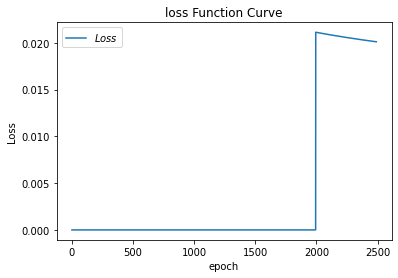

In [65]:
# 训练部分
now_time = time.time()
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            y = tf.matmul(x_train,w1) + b1
            y = tf.nn.softmax(y)
            y_ = tf.one_hot(y_train,depth=3)
            loss = tf.reduce_mean(tf.square(y_-y))
            loss_all += loss.numpy()
            
        grads = tape.gradient(loss,[w1,b1])
        
        w1.assign_sub(lr*grads[0])
        b1.assign_sub(lr*grads[1])
        
    print("epoch: {},loss:{}".format(epoch,loss_all/(step+1)))
    train_loss_results.append(loss_all/(step+1))
    loss_all = 0
    
    
    # 测试部分
    total_correct, total_number = 0,0
    for x_test,y_test in test_db:
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)
        pred = tf.cast(pred, dtype = y_test.dtype)
        
        correct = tf.cast(tf.equal(pred,y_test),dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]
        
    acc = total_correct/total_number
    test_acc.append(acc)
    print("test_acc:",acc)
    print("---------------------------------")
    
total_time = time.time() - now_time
print("total_time:",total_time)


# 绘制loss曲线
plt.title("loss Function Curve")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(train_loss_results,label="$Loss$")
plt.legend()
plt.show()

epoch: 0,loss:0.018551890971139073
test_acc: 1.0
---------------------------------
epoch: 1,loss:0.01847888366319239
test_acc: 1.0
---------------------------------
epoch: 2,loss:0.0184209612198174
test_acc: 1.0
---------------------------------
epoch: 3,loss:0.018367729848250747
test_acc: 1.0
---------------------------------
epoch: 4,loss:0.018310476327314973
test_acc: 1.0
---------------------------------
epoch: 5,loss:0.01826425944454968
test_acc: 1.0
---------------------------------
epoch: 6,loss:0.018245982937514782
test_acc: 1.0
---------------------------------
epoch: 7,loss:0.018255047500133514
test_acc: 1.0
---------------------------------
epoch: 8,loss:0.018277093768119812
test_acc: 1.0
---------------------------------
epoch: 9,loss:0.01829752023331821
test_acc: 1.0
---------------------------------
epoch: 10,loss:0.018309161998331547
test_acc: 1.0
---------------------------------
epoch: 11,loss:0.018311554100364447
test_acc: 1.0
---------------------------------
epoch: 

test_acc: 1.0
---------------------------------
epoch: 99,loss:0.01818718179129064
test_acc: 1.0
---------------------------------
epoch: 100,loss:0.018186010420322418
test_acc: 1.0
---------------------------------
epoch: 101,loss:0.01818483928218484
test_acc: 1.0
---------------------------------
epoch: 102,loss:0.018183666979894042
test_acc: 1.0
---------------------------------
epoch: 103,loss:0.018182490719482303
test_acc: 1.0
---------------------------------
epoch: 104,loss:0.018181315157562494
test_acc: 1.0
---------------------------------
epoch: 105,loss:0.01818014495074749
test_acc: 1.0
---------------------------------
epoch: 106,loss:0.018178972182795405
test_acc: 1.0
---------------------------------
epoch: 107,loss:0.01817779429256916
test_acc: 1.0
---------------------------------
epoch: 108,loss:0.018176624551415443
test_acc: 1.0
---------------------------------
epoch: 109,loss:0.018175459001213312
test_acc: 1.0
---------------------------------
epoch: 110,loss:0.0181

epoch: 215,loss:0.01805441500619054
test_acc: 1.0
---------------------------------
epoch: 216,loss:0.018053303472697735
test_acc: 1.0
---------------------------------
epoch: 217,loss:0.018052190309390426
test_acc: 1.0
---------------------------------
epoch: 218,loss:0.01805107109248638
test_acc: 1.0
---------------------------------
epoch: 219,loss:0.01804996025748551
test_acc: 1.0
---------------------------------
epoch: 220,loss:0.018048842903226614
test_acc: 1.0
---------------------------------
epoch: 221,loss:0.018047729041427374
test_acc: 1.0
---------------------------------
epoch: 222,loss:0.01804662123322487
test_acc: 1.0
---------------------------------
epoch: 223,loss:0.018045511096715927
test_acc: 1.0
---------------------------------
epoch: 224,loss:0.018044409807771444
test_acc: 1.0
---------------------------------
epoch: 225,loss:0.018043301301077008
test_acc: 1.0
---------------------------------
epoch: 226,loss:0.018042187206447124
test_acc: 1.0
------------------

test_acc: 1.0
---------------------------------
epoch: 331,loss:0.017928353510797024
test_acc: 1.0
---------------------------------
epoch: 332,loss:0.017927298322319984
test_acc: 1.0
---------------------------------
epoch: 333,loss:0.017926235450431705
test_acc: 1.0
---------------------------------
epoch: 334,loss:0.017925170250236988
test_acc: 1.0
---------------------------------
epoch: 335,loss:0.017924116691574454
test_acc: 1.0
---------------------------------
epoch: 336,loss:0.01792305614799261
test_acc: 1.0
---------------------------------
epoch: 337,loss:0.017921997932717204
test_acc: 1.0
---------------------------------
epoch: 338,loss:0.017920948332175612
test_acc: 1.0
---------------------------------
epoch: 339,loss:0.017919892212376
test_acc: 1.0
---------------------------------
epoch: 340,loss:0.017918836558237672
test_acc: 1.0
---------------------------------
epoch: 341,loss:0.01791777741163969
test_acc: 1.0
---------------------------------
epoch: 342,loss:0.0179

test_acc: 1.0
---------------------------------
epoch: 442,loss:0.01781345414929092
test_acc: 1.0
---------------------------------
epoch: 443,loss:0.01781244669109583
test_acc: 1.0
---------------------------------
epoch: 444,loss:0.017811432480812073
test_acc: 1.0
---------------------------------
epoch: 445,loss:0.01781042478978634
test_acc: 1.0
---------------------------------
epoch: 446,loss:0.017809416400268674
test_acc: 1.0
---------------------------------
epoch: 447,loss:0.017808402655646205
test_acc: 1.0
---------------------------------
epoch: 448,loss:0.01780739682726562
test_acc: 1.0
---------------------------------
epoch: 449,loss:0.017806387273594737
test_acc: 1.0
---------------------------------
epoch: 450,loss:0.017805380281060934
test_acc: 1.0
---------------------------------
epoch: 451,loss:0.017804373521357775
test_acc: 1.0
---------------------------------
epoch: 452,loss:0.01780336769297719
test_acc: 1.0
---------------------------------
epoch: 453,loss:0.0178

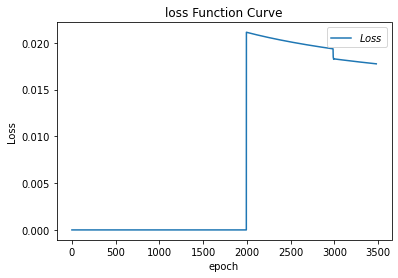

In [67]:
# SGDM 
m_w,m_b = 0,0
beta = 0.9

# 训练部分
now_time = time.time()
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            y = tf.matmul(x_train,w1) + b1
            y = tf.nn.softmax(y)
            y_ = tf.one_hot(y_train,depth=3)
            loss = tf.reduce_mean(tf.square(y_-y))
            loss_all += loss.numpy()
            
        grads = tape.gradient(loss,[w1,b1])
        
        # sgd-momentum
        m_w = beta*m_w + (1-beta)*grads[0]
        m_b = beta*m_b + (1-beta)*grads[1]
        w1.assign_sub(lr* m_w)
        b1.assign_sub(lr* m_b)
        
    print("epoch: {},loss:{}".format(epoch,loss_all/(step+1)))
    train_loss_results.append(loss_all/(step+1))
    loss_all = 0
    
    
    # 测试部分
    total_correct, total_number = 0,0
    for x_test,y_test in test_db:
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)
        pred = tf.cast(pred, dtype = y_test.dtype)
        
        correct = tf.cast(tf.equal(pred,y_test),dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]
        
    acc = total_correct/total_number
    test_acc.append(acc)
    print("test_acc:",acc)
    print("---------------------------------")
    
total_time = time.time() - now_time
print("total_time:",total_time)


# 绘制loss曲线
plt.title("loss Function Curve")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(train_loss_results,label="$Loss$")
plt.legend()
plt.show()

total_time: 0.0


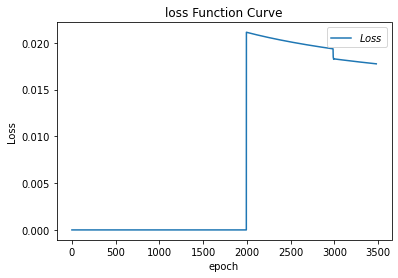

In [70]:
# adagrad
v_w,v_b = 0,0

# 训练部分
now_time = time.time()
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            y = tf.matmul(x_train,w1) + b1
            y = tf.nn.softmax(y)
            y_ = tf.one_hot(y_train,depth=3)
            loss = tf.reduce_mean(tf.square(y_-y))
            loss_all += loss.numpy()
            
        grads = tape.gradient(loss,[w1,b1])
        
        # adagrad
        v_w += tf.square(grads[0])
        v_b += tf.square(grads[1])
        
        w1.assign_sub(lr*grads[0]/tf.sqrt(v_w))
        b1.assign_sub(lr*grads[1]/tf.sqrt(v_b))
        
    print("epoch: {},loss:{}".format(epoch,loss_all/(step+1)))
    train_loss_results.append(loss_all/(step+1))
    loss_all = 0
    
    
    # 测试部分
    total_correct, total_number = 0,0
    for x_test,y_test in test_db:
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)
        pred = tf.cast(pred, dtype = y_test.dtype)
        
        correct = tf.cast(tf.equal(pred,y_test),dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]
        
    acc = total_correct/total_number
    test_acc.append(acc)
    print("test_acc:",acc)
    print("---------------------------------")
    
total_time = time.time() - now_time
print("total_time:",total_time)


# 绘制loss曲线
plt.title("loss Function Curve")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(train_loss_results,label="$Loss$")
plt.legend()
plt.show()

total_time: 0.0


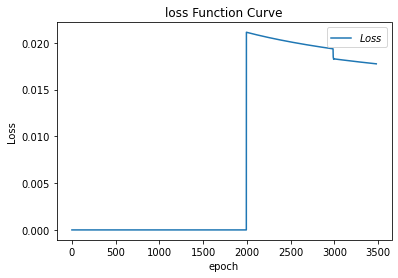

In [71]:
# rmsprop
v_w,v_b = 0,0
beta = 0.9

# 训练部分
now_time = time.time()
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            y = tf.matmul(x_train,w1) + b1
            y = tf.nn.softmax(y)
            y_ = tf.one_hot(y_train,depth=3)
            loss = tf.reduce_mean(tf.square(y_-y))
            loss_all += loss.numpy()
            
        grads = tape.gradient(loss,[w1,b1])
        
        # rmsprop
        v_w = beta*v_w + (1-beta)*tf.square(grads[0])
        v_b = beta*v_b +(1-beta)*tf.square(grads[1])
        
        w1.assign_sub(lr*grads[0]/tf.sqrt(v_w))
        b1.assign_sub(lr*grads[1]/tf.sqrt(v_b))
        
    print("epoch: {},loss:{}".format(epoch,loss_all/(step+1)))
    train_loss_results.append(loss_all/(step+1))
    loss_all = 0
    
    
    # 测试部分
    total_correct, total_number = 0,0
    for x_test,y_test in test_db:
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)
        pred = tf.cast(pred, dtype = y_test.dtype)
        
        correct = tf.cast(tf.equal(pred,y_test),dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]
        
    acc = total_correct/total_number
    test_acc.append(acc)
    print("test_acc:",acc)
    print("---------------------------------")
    
total_time = time.time() - now_time
print("total_time:",total_time)


# 绘制loss曲线
plt.title("loss Function Curve")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(train_loss_results,label="$Loss$")
plt.legend()
plt.show()

total_time: 0.0


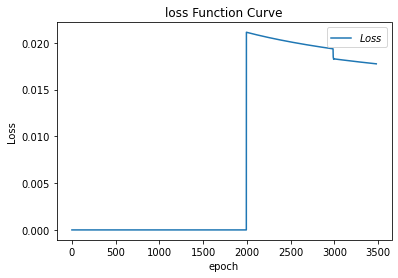

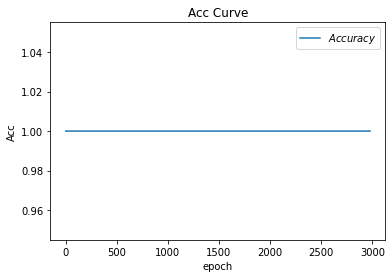

In [72]:
# adam
m_w, m_b = 0,0
v_w,v_b = 0,0
beta1,beta2 = 0.9,0.999
delta_w, delta_b = 0,0
global_step = 0

# 训练部分
now_time = time.time()
for epoch in range(epoch):
    for step,(x_train,y_train) in enumerate(train_db):
        
        global_step += 1
        
        with tf.GradientTape() as tape:
            y = tf.matmul(x_train,w1) + b1
            y = tf.nn.softmax(y)
            y_ = tf.one_hot(y_train,depth=3)
            loss = tf.reduce_mean(tf.square(y_-y))
            loss_all += loss.numpy()
            
        grads = tape.gradient(loss,[w1,b1])
        
        # adam
        m_w = beta1 * m_w + (1-beta1)*grads[0]
        m_b = beta1 * m_b + (1- beta1)*grad[1]
        v_w = beta2 * v_w + (1-beta)*tf.square(grads[0])
        v_b = beta2 * v_b + (1-beta)*tf.square(grads[1])
        
        m_w_correction = m_w/(1-tf.pow(beta1,int(global_step)))
        m_b_correction = m_b/(1-tf.pow(beta1,int(global_step)))
        v_w_correction = v_w/(1-tf.pow(beta2,int(global_step)))
        v_b_correction = v_b/(1-tf.pow(beta2,int(global_step)))
        
        w1.assign_sub(lr*m_w_correction/tf.sqrt(v_w_correction))
        b1.assign_sub(lr*m_b_correction/tf.sqrt(v_b_correction))
        
    print("epoch: {},loss:{}".format(epoch,loss_all/(step+1)))
    train_loss_results.append(loss_all/(step+1))
    loss_all = 0
    
    
    # 测试部分
    total_correct, total_number = 0,0
    for x_test,y_test in test_db:
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)
        pred = tf.cast(pred, dtype = y_test.dtype)
        
        correct = tf.cast(tf.equal(pred,y_test),dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]
        
    acc = total_correct/total_number
    test_acc.append(acc)
    print("test_acc:",acc)
    print("---------------------------------")
    
total_time = time.time() - now_time
print("total_time:",total_time)


# 绘制loss曲线
plt.title("loss Function Curve")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(train_loss_results,label="$Loss$")
plt.legend()
plt.show()

plt.title("Acc Curve")
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.plot(test_acc,label="$Accuracy$")
plt.legend()
plt.show()